# Predicting Perfume Rating and Popularity
# Part II
# ==================================================

# 1. read and pre-process the data
# 2. data analysis
# 3. apply machine learning (ML) algorithms to make predictions

# ==================================================

# 1. read and pre-process the data

In [1]:
#######################
###### read data ######
#######################
import csv
import re
from random import shuffle
import random

###########################################
# read the dataset (str)
# convert dataset to appropriate data structure (list)
with open('fragrantica_group_database.tsv', 'r') as f:
    reader = csv.reader(f, delimiter='\t') # don't forget the delimiter
    data = []
    for row in reader:
        data.append(row)
    print(data[0]) # print the fieldname
    data = data[1:] # get rid of the first row (fieldname)

###########################################
# convert the inputs (str) into appropriate list
for row in data:
    
    # name: convert str to a list of [brand namde, perfume naame]
    name = row[0]
    row[0] = name.split("'")[1::2]
    
    # rate: convert str to a list of [rate (float), # ratings (int), # reviews (int)]
    rate = row[1]
    floats = [float(x) for x in re.findall("[-+]?\d*\.\d+|[-+]?\d+", rate)] 
    row[1] = [floats[0], int(floats[1]), int(floats[2])]
    
    # ownership: convert str to # votes for "I have it", "had", "want", and "signuatre"
    own = row[2]
    own_list = [int(x) for x in re.findall("[-+]?\d*\.\d+|[-+]?\d+", own)]
    row[2] = own_list[0]
    
    # rate_detail: convert str to a list of floats [% love, % like, % dislike]
    rate_detail = row[3]
    row[3] = [float(x) for x in re.findall("[-+]?\d*\.\d+|[-+]?\d+", rate_detail)]
    
    # season: convert str to a list of floats [% win, % spr, % sum, % aut]
    season = row[4]
    row[4] = [float(x) for x in re.findall("[-+]?\d*\.\d+|[-+]?\d+", season)]
    
    # day_night: convert str to a list of floats [% day, % night]
    day_night = row[5]
    row[5] = [float(x) for x in re.findall("[-+]?\d*\.\d+|[-+]?\d+", day_night)]
    
    # longevity: convert str to a list of floats [% poor, weak, moderate, 
    # long lasting, vrey long lasting]
    longevity = row[6]
    row[6] = [float(x) for x in re.findall("[-+]?\d*\.\d+|[-+]?\d+", longevity)]
    
    # sillage: convert str to a list of floats [% soft, moderate, heavy, enormous]
    sillage = row[7]
    row[7] = [float(x) for x in re.findall("[-+]?\d*\.\d+|[-+]?\d+", sillage)]
    
    # main_accords: convert str to a list of strs [accord_1, accord_2, ...]
    accords = row[8]
    row[8] = accords.split("'")[1::2]
    
    # notes: convert str to a list of strs [note_1, note_2, ...]
    notes = row[9]
    row[9] = notes.split("'")[1::2]
    
    # user_notes: covnert str to a list of strs [note_1, note_2, ...]
    # the order of notes are sorted based on the user votes
    user_notes = row[10]
    notes_us = user_notes.split("'")[1::2]
    votes_us = [float(x) for x in re.findall("[-+]?\d*\.\d+|[-+]?\d+", user_notes)]
    user_notes = {}
    for x in notes_us:
        x_id = notes_us.index(x)
        user_notes[x] = votes_us[x_id]
    row[10] = sorted(user_notes, key=user_notes.get, reverse=True)
    
    # group: covnert str to a list of strs [group_1, group_2, ...]
    group = row[11]
    row[11] = group.split(" ")

data_filter = [] 
for i in range(0, len(data)):
    row = data[i][6] + data[i][7]
    flag = 0
    for x in row:
        if x < 0:
            flag = 1
            break
    if flag == 0:
        data_filter.append(data[i])
data = data_filter
    
###########################################
# shuffle the order of the perfume in the data
random.shuffle(data)
print ("****************************************************")
print ("Done importing, processing and shuffling the data!")
print ("The total number of imported perfumes is {0}".format(len(data)))
print ("****************************************************")


['1. name', '2. rate', '3. ownership', '4. rate_detail', '5. season', '6. day_night', '7. longevity', '8. sillage', '9. main accords', '10. notes', '11. user notes ', '12. olfactory group']
****************************************************
Done importing, processing and shuffling the data!
The total number of imported perfumes is 22835
****************************************************


In [4]:
##########################################################
####### convert notes/accords into indicator vector ######
##########################################################

#############################################
# convert notes list into an indicator matrix
# first, construct a token list for the notes, which consist of the most common notes
def get_notes_token (data, num_notes):
    notes_token = []
    for row in data:
        # use the user_notes
        for x in row[10]:
            notes_token.append(x)
            
    # count the appearance of each note in the whole list
    a = [[x, notes_token.count(x)] for x in set(notes_token)]
    print("******************************************************************************")
    print("The total number of notes that appear in the data base is : {0}".format(len(a)))
    print("But, here we only use the most common {0} notes to construct the token list".format(num_notes))
    print("******************************************************************************")

    # sort the notes by the number of appearance
    a_sorted = sorted(a, key = itemgetter(1), reverse=True)
    
    # only use the most common #num_notes notes in the token list
    notes_token_list = [x[0] for x in a_sorted[:num_notes]]
    print ("Done constructing the token list for the notes")
    return notes_token_list
    
# second, convert the user_notes to an indicator matrix     
def get_notes(data, num_notes):
    notes_token_list = get_notes_token(data,num_notes) # construct the token list using the entire data
    # convert notes list to a indicator matrix, corresponding notes stored in notes_list
    notes = []
    for row in data:
        notes_input = row[10]
        notes_output = [int(x in notes_input) for x in notes_token_list]
        notes.append(notes_output)
    
    print ("Done converting user_notes to indicator matrix")
    return notes

###########################################
# convert accords list into an indicator matrix
# first, construct the token list for the accords

def get_accords_token (data, num_accords):
    accords_token = []
    for row in data:
    # use the user_notes
        for x in row[8]:
            accords_token.append(x)

    # count the appearance of each note in the whole list
    a = [[x, accords_token.count(x)] for x in set(accords_token)]
    print("*********************************************************************************")
    print("The total number of accords that appear in the data base is : {0}".format(len(a)))
    print("But, here we only use the most common {0} accords to construct the token list".format(num_accords))
    print("*********************************************************************************")
    
    # sort the notes by the number of appearance
    a_sorted = sorted(a, key = itemgetter(1), reverse=True)

    # only use the most common #num_accords accords in the token list
    accords_token_list = [x[0] for x in a_sorted[:num_accords]]
    print ("Done constructing the token list for the accords")
    return accords_token_list

# second, convert the user_notes to an indicator matrix     
def get_accords(data, num_accords):
    # construct the token list using the entire data
    accords_token_list = get_accords_token(data,num_accords)
    # convert accords list to a indicator matrix, corresponding accords stored in accords_list
    accords = []
    for row in data:
        accords_input = row[8]
        accords_output = [int(x in accords_input) for x in accords_token_list]
        accords.append(accords_output)
    
    print ("Done converting accords to indicator matrix")
    return accords

In [5]:
########################################
####### convert popularity/rating ######
########################################

###########################################
# define a few functions
from collections import Counter
from operator import itemgetter

###########################################
# classification/categoring function: convert continuous values to discrete values
def get_class (list_before, num_label):
    list_sort = sorted(list_before)
    volume = int(len(list_before)/num_label)
    thre = []
    for i in range(1, num_label):
        thre.append(list_sort[i*volume])
    #print ("The threshold for classification:")
    #print (thre)
    list_after = []
    for x in list_before:
        label = 0
        for threshold in thre:
            if x < threshold:
                label = thre.index(threshold) + 1
                break
        if label == 0:
            label = len(thre) + 1
        list_after.append(label)
    #print ("Done categoring")
    return list_after            


###########################################
# obtain the popularity of a perfume

def get_pop (data, which, num_class):
    pop = []
    pop_0 = []
    pop_1 = []
    for row in data:
        count_r = row[1][1]
        pop_0.append(count_r)
        count_own = row[2]
        pop_1.append(count_own)
    if which == 0:
        # measure the popularity from the # of total ratings
        pop = pop_0
    else:
        # measure the popularity from the onwership
        pop = pop_1
    print ("Done computing the popularity")
    
    if num_class == 1:
        return pop # continous - for regression
    else:
        pop_class = get_class(pop, num_class)
        return pop_class # discrete - for classification

###########################################
# obtain the rate of a perfume

def get_rate(data, which, num_class):
    rate = []
    rate_class = []
    if which == 0:
        # measure the rate from the rate score
        for row in data:
            score = row[1][0]
            rate.append(score)
        rate_class = get_class(rate, num_class)
    else:
        # measure the rate from the votes for "love", "like", and "dislike"
        for row in data:
            # discrete
            rate_class.append(row[3].index(max(row[3])))
            # continous
            rate.append(2 * row[3][0] + 1 * row[3][1])
    print ("Done computing the rate")
    
    if num_class == 1:
        return rate # continous - for regression
    else:
        return rate_class # discrete - for classification


In [6]:
#############################################################################################
####### convert season/day_night/longevity/sillage into appropriate matrices or arrays ######
#############################################################################################

###########################################
# obtain the longevity of a perfume

def get_long(data):
    long = []
    for row in data:
        long.append(row[6])
    print ("Done computing the longevity")
    return long # continous - regression

###########################################
# obtain the sillage of a perfume

def get_sillage(data):
    sil = []
    for row in data:
        sil.append(row[7])
    print ("Done computing the sillage")
    return sil # continous - regression

###########################################
# obtain the day_night of a perfume

def get_day_night(data):
    day = []
    for row in data:
        day.append(row[5])
    print ("Done computing the day_vs_night")
    return day # continous - regression

###########################################
# obtain the season of a perfume

def get_season(data):
    winter = []
    for row in data:
        winter.append(row[4])
    print ("Done computing the season")
    return winter # continous - regression


In [7]:
# targets
rate = get_rate(data, 0, 1) # compute rate from the rating score, continous-valued
popularity_dis = get_pop (data, 0, 2) # compute popularity from the total number of votings, discrete
popularity_con = get_pop (data, 0, 1) # compute popularity from the total number of votings, continous-valued

# inputs/targets
season = get_season(data)
day_night = get_day_night(data)
longevity = get_long(data)
sillage = get_sillage(data)

# inputs
accords = get_accords(data,40)
notes = get_notes(data, 200)

Done computing the rate
Done computing the popularity
Done computing the popularity
Done computing the season
Done computing the day_vs_night
Done computing the longevity
Done computing the sillage
*********************************************************************************
The total number of accords that appear in the data base is : 73
But, here we only use the most common 40 accords to construct the token list
*********************************************************************************
Done constructing the token list for the accords
Done converting accords to indicator matrix
******************************************************************************
The total number of notes that appear in the data base is : 1235
But, here we only use the most common 200 notes to construct the token list
******************************************************************************
Done constructing the token list for the notes
Done converting user_notes to indicator matrix


# 2. data analysis

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [10]:
############################
# convert list to array

data_to_use = []
for i in range(len(data)):
    # column names:
    # column 1: perfume name, column 2: brand name
    # column 3: perfume rate score
    # column 4, 5: perfume popularity - total number of voting, category
    # column 6, 7: votes% for day, night
    # column 8, 9, 10, 11: votes% for win, spr, sum, fall
    # column 12, 13, 14, 15, 16: votes% for longevity of poor, weak, moderate, long lasting, very long lasting
    # column 17, 18, 19, 20: votes% for sillage of soft, moderate, heavy, enormous
    # column 21-220: 200 notes indicator, 200 notes stored in notes_token_list
    # column 221-260: 40 accords indicator, 40 accords stored in accords_token_list
    x = data[i][0][1::-1] + [rate[i]] + [popularity_con[i]] + [popularity_dis[i] ]
    x = x + day_night[i] + season[i] + longevity[i] + sillage[i] + notes[i][:200] + accords[i][:40]    
    # there are some perfumes missing some information, such as brand name
    if len(x) == 260:
        data_to_use.append(x)    
data_array = np.array(data_to_use)

In [126]:
#####################################
# construct DataFrame from the array

# list the column labels:
column_names = ["perfume name", "brand name", "rate score", "# of voting", "popular or not", 
                "day", "night", "win", "spr", "sum", "aut", 
                "longevity of poor", "longevity of weak", "longevity of moderate", 
                "longevity of long lasting", "longevity of very long lasting"
                , "sillage of soft", "sillage of moderate", "sillage of heavy"
                 , "sillage of enormous"]
notes_token_list = get_notes_token(data, 200)
accords_token_list = get_accords_token(data, 40)
column_names = column_names + notes_token_list + accords_token_list 

df = pd.DataFrame(data_array, columns=column_names)

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 500

# change the data type from str to appropriate tyep
df.iloc[:, 2] = df.iloc[:, 2].astype(np.float)
df.iloc[:, 3:5] = df.iloc[:, 3:5].astype(np.int)
df.iloc[:, 5:20] = df.iloc[:, 5:20].astype(np.float)
df.iloc[:, 20:] = df.iloc[:, 20:].astype(np.int)

******************************************************************************
The total number of notes that appear in the data base is : 1235
But, here we only use the most common 200 notes to construct the token list
******************************************************************************
Done constructing the token list for the notes
*********************************************************************************
The total number of accords that appear in the data base is : 73
But, here we only use the most common 40 accords to construct the token list
*********************************************************************************
Done constructing the token list for the accords


## Display some data examples

In [371]:
###########################
# display the data

df.head(n=10)

,perfume name,brand name,rate score,# of voting,popular or not,day,night,win,spr,sum,aut,longevity of poor,longevity of weak,longevity of moderate,longevity of long lasting,longevity of very long lasting,sillage of soft,sillage of moderate,sillage of heavy,sillage of enormous,Musk,Sandalwood,Jasmine,Bergamot,Amber,Rose,Patchouli,Vanilla,Cedar,Mandarin Orange,Vetiver,Lily-of-the-Valley,Tonka Bean,Lavender,Lemon,Violet,Ylang-Ylang,iris,Grapefruit,Orange Blossom,Peach,Cardamom,Freesia,Oakmoss,Vanille,Orange,Leather,Geranium,Virginia Cedar,Benzoin,Cinnamon,Tuberose,Incense,Neroli,Pink Pepper,Black Currant,Peony,Nutmeg,Woody Notes,Citruses,Agarwood (Oud),Woodsy Notes,Green Notes,White Musk,Pepper,Ginger,Gardenia,Coriander,Magnolia,Heliotrope,Raspberry,Carnation,Mint,Amalfi Lemon,Floral Notes,Lily,Pear,Labdanum,Orchid,Lime,Saffron,Plum,Basil,Aldehydes,Violet Leaf,Orris Root,Pineapple,African Orange flower,Galbanum,Spices,Tangerine,Sage,Guaiac Wood,Rosemary,oak moss,Mimosa,Tobacco,Petitgrain,Ambergris,Honey,Apple,Cloves,Fruity Notes,Lotus,Osmanthus,Coconut,Cyclamen,Honeysuckle,Black Pepper,Artemisia,Caramel,Tea,Apricot,Olibanum,Melon,Clary Sage,Red Berries,Moss,Narcissus,Litchi,Cypress,Cashmere Wood,Bitter Orange,Water Lily,Clove,Spicy Notes,Red Apple,Cassis,Lilac,Almond,Myrrh,Blackberry,Brazilian Rosewood,Hyacinth,Sea Notes,Juniper,Caraway,Frangipani,Star Anise,French labdanum,Water Notes,vetyver,Passionfruit,White Flowers,Anise,Bulgarian Rose,Styrax,Juniper Berries,Ambrette (Musk Mallow),Green Apple,Thyme,Yuzu,Opoponax,Myrhh,Sea water,Praline,Coffee,Mango,Tiare Flower,Tarragon,Suede,Watermelon,Jasmine Sambac,Sugar,Green Leaves,Birch,Civet,Rum,Lemon Verbena,Fig,Palisander Rosewood,Big Strawberry,Angelica,Cacao,Licorice,Chamomile,Cassia,Blood Orange,elemi,Pomegranate,Orris,Grass,Green Tea,white honey,resins,Powdery Notes,Pink Grapefruit,Teak Wood,Red Currant,Castoreum,Tolu Balsam,Clementine,Fig Leaf,Bamboo,Vanila,Turkish Rose,Cherry,Milk,tincture of rose,Watery Notes,Marigold,Fir,Hiacynth,Immortelle,Ivy,Granny Smith apple,Resin,Hibiscus,Wormwood,Damask Rose,Bay Leaf,Citron,Cumin,White Pepper,White Amber,Nectarine,Cashmeran,Madagascar Vanilla,Peru Balsam,Oak,woody,citrus,floral,sweet,aromatic,fresh spicy,white floral,fruity,powdery,warm spicy,balsamic,musky,green,vanilla,rose,fresh,amber,patchouli,animalic,earthy,aquatic,leather,herbal,smoky,soft spicy,yellow floral,ozonic,oud,tropical,tuberose,marine,cinnamon,honey,sour,cacao,tobacco,aldehydic,caramel,coconut,almond
0,Pop Rock! Shakira for women,Shakira,5.00,6,1,0.666667,0.333333,0.012987,0.649351,0.012987,0.324675,0.000000,0.500000,0.000000,0.500000,0.000000,0.333333,0.000000,0.333333,0.333333,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rouge Avignon Phaedon for women and men,Phaedon,3.93,112,2,0.208955,0.791045,0.392308,0.161538,0.130769,0.315385,0.086957,0.043478,0.173913,0.304348,0.391304,0.212121,0.272727,0.212121,0.303030,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,Amber Sage Machado for women and men,Sage Machado,3.54,14,1,0.445312,0.554688,0.367742,0.270968,0.180645,0.180645,0.000000,0.000000,0.000000,0.000000,1.0000

## Display the 100 most popular perfumes in the world!

In [372]:
df.sort('# of voting', ascending=0).head(100)

,perfume name,brand name,rate score,# of voting,popular or not,day,night,win,spr,sum,aut,longevity of poor,longevity of weak,longevity of moderate,longevity of long lasting,longevity of very long lasting,sillage of soft,sillage of moderate,sillage of heavy,sillage of enormous,Musk,Sandalwood,Jasmine,Bergamot,Amber,Rose,Patchouli,Vanilla,Cedar,Mandarin Orange,Vetiver,Lily-of-the-Valley,Tonka Bean,Lavender,Lemon,Violet,Ylang-Ylang,iris,Grapefruit,Orange Blossom,Peach,Cardamom,Freesia,Oakmoss,Vanille,Orange,Leather,Geranium,Virginia Cedar,Benzoin,Cinnamon,Tuberose,Incense,Neroli,Pink Pepper,Black Currant,Peony,Nutmeg,Woody Notes,Citruses,Agarwood (Oud),Woodsy Notes,Green Notes,White Musk,Pepper,Ginger,Gardenia,Coriander,Magnolia,Heliotrope,Raspberry,Carnation,Mint,Amalfi Lemon,Floral Notes,Lily,Pear,Labdanum,Orchid,Lime,Saffron,Plum,Basil,Aldehydes,Violet Leaf,Orris Root,Pineapple,African Orange flower,Galbanum,Spices,Tangerine,Sage,Guaiac Wood,Rosemary,oak moss,Mimosa,Tobacco,Petitgrain,Ambergris,Honey,Apple,Cloves,Fruity Notes,Lotus,Osmanthus,Coconut,Cyclamen,Honeysuckle,Black Pepper,Artemisia,Caramel,Tea,Apricot,Olibanum,Melon,Clary Sage,Red Berries,Moss,Narcissus,Litchi,Cypress,Cashmere Wood,Bitter Orange,Water Lily,Clove,Spicy Notes,Red Apple,Cassis,Lilac,Almond,Myrrh,Blackberry,Brazilian Rosewood,Hyacinth,Sea Notes,Juniper,Caraway,Frangipani,Star Anise,French labdanum,Water Notes,vetyver,Passionfruit,White Flowers,Anise,Bulgarian Rose,Styrax,Juniper Berries,Ambrette (Musk Mallow),Green Apple,Thyme,Yuzu,Opoponax,Myrhh,Sea water,Praline,Coffee,Mango,Tiare Flower,Tarragon,Suede,Watermelon,Jasmine Sambac,Sugar,Green Leaves,Birch,Civet,Rum,Lemon Verbena,Fig,Palisander Rosewood,Big Strawberry,Angelica,Cacao,Licorice,Chamomile,Cassia,Blood Orange,elemi,Pomegranate,Orris,Grass,Green Tea,white honey,resins,Powdery Notes,Pink Grapefruit,Teak Wood,Red Currant,Castoreum,Tolu Balsam,Clementine,Fig Leaf,Bamboo,Vanila,Turkish Rose,Cherry,Milk,tincture of rose,Watery Notes,Marigold,Fir,Hiacynth,Immortelle,Ivy,Granny Smith apple,Resin,Hibiscus,Wormwood,Damask Rose,Bay Leaf,Citron,Cumin,White Pepper,White Amber,Nectarine,Cashmeran,Madagascar Vanilla,Peru Balsam,Oak,woody,citrus,floral,sweet,aromatic,fresh spicy,white floral,fruity,powdery,warm spicy,balsamic,musky,green,vanilla,rose,fresh,amber,patchouli,animalic,earthy,aquatic,leather,herbal,smoky,soft spicy,yellow floral,ozonic,oud,tropical,tuberose,marine,cinnamon,honey,sour,cacao,tobacco,aldehydic,caramel,coconut,almond
15696,Angel Thierry Mugler for women,Thierry Mugler,3.13,8622,2,0.279570,0.720430,0.535714,0.107143,0.089286,0.267857,0.010684,0.016382,0.065527,0.249288,0.658120,0.030137,0.098630,0.271233,0.600000,1,0,1,1,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1311,Coco Mademoiselle Chanel for women,Chanel,4.10,7634,2,0.586207,0.413793,0.243478,0.313043,0.156522,0.286957,0.035928,0.049401,0.121257,0.343563,0.449850,0.069820,0.295796,0.451201,0.183183,0,0,1,1,0,0,1,1,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11337,D&G Light Blue Dolce&Gabbana for women,Dolce&Gabbana,3.65,7615,2,0.897959,0.102041,0.060150,0.285714,0.593985,0.060150,0.107178,0.178958,

## Plot distribution of
## i. rating
## ii. total number of voting

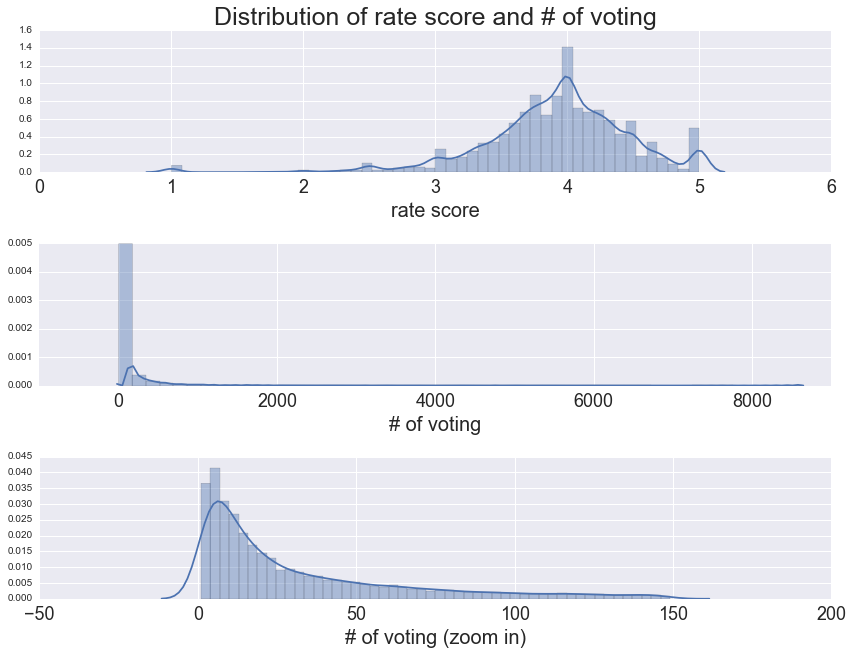

In [128]:
y_rate = df['rate score'].tolist()
y_voting = df['# of voting'].tolist()
y_voting_zoom = [x for x in y_voting if x < 150]

fig = plt.figure(figsize=(8,10))

plt.subplot(3, 1, 1)
sns.distplot(y_rate)
plt.xlabel('rate score', fontsize=20)
plt.xticks(fontsize=18)
plt.title('Distribution of rate score and # of voting', fontsize=25)

plt.subplot(3, 1, 2)
sns.distplot(y_voting)
plt.xlabel('# of voting', fontsize=20)
plt.xticks(fontsize=18)

plt.subplot(3, 1, 3)
sns.distplot(y_voting_zoom)
plt.xlabel('# of voting (zoom in)', fontsize=20)
plt.xticks(fontsize=18)

plt.subplots_adjust(bottom=0.2, right=1.5, top=0.99, hspace=0.5)

## Plot proportions of 
## i. day vs. night  
## ii. four seasons
## iii. longevity
## iv. sillage

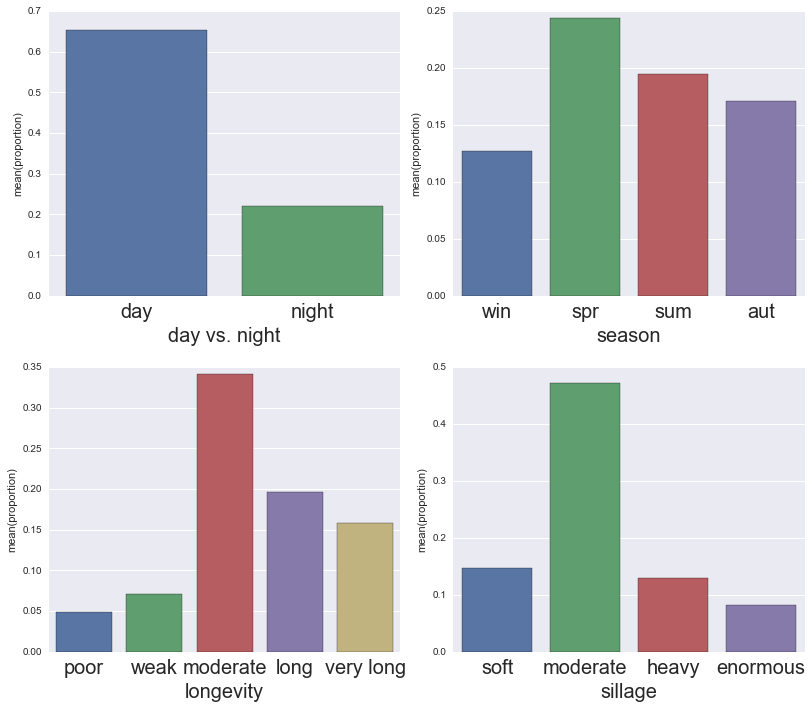

In [155]:
fig = plt.figure(figsize=(12,10))

# day vs. night
df_day = df.loc[df['day'] > df['night']]
df_night = df.loc[df['day'] < df['night']]
ratio_day_night = pd.DataFrame({'day vs. night': ['day', 'night'], 'proportion': [df_day.shape[0]/df.shape[0], 
                                                                 df_night.shape[0]/df.shape[0]]})
plt.subplot(2, 2, 1)
sns.barplot(x='day vs. night', y='proportion', data=ratio_day_night)
plt.xlabel("day vs. night", fontsize=20)
plt.xticks(fontsize=20)

# four seasons
df_win = df.loc[(df['win'] > df['spr']) & (df['win'] > df['sum']) & (df['win'] > df['aut'])]
df_spr = df.loc[(df['spr'] > df['win']) & (df['spr'] > df['sum']) & (df['spr'] > df['aut'])]
df_sum = df.loc[(df['sum'] > df['win']) & (df['sum'] > df['spr']) & (df['sum'] > df['aut'])]
df_aut = df.loc[(df['aut'] > df['win']) & (df['aut'] > df['spr']) & (df['aut'] > df['sum'])]
ratio_season = pd.DataFrame({'season': ['win', 'spr', 'sum', 'aut'], 'proportion': [df_win.shape[0]/df.shape[0],
                                                                                    df_spr.shape[0]/df.shape[0], 
                                                                                    df_sum.shape[0]/df.shape[0], 
                                                                                    df_aut.shape[0]/df.shape[0]]})
plt.subplot(2, 2, 2)
sns.barplot(x='season', y='proportion', data=ratio_season)
plt.xlabel("season", fontsize=20)
plt.xticks(fontsize=20)

# longevity
df_poor = df.loc[(df.iloc[:,11] > df.iloc[:,12]) & (df.iloc[:,11] > df.iloc[:,13]) & (df.iloc[:,11] > df.iloc[:,14])
                & (df.iloc[:,11] > df.iloc[:,15])]
df_weak = df.loc[(df.iloc[:,12] > df.iloc[:,11]) & (df.iloc[:,12] > df.iloc[:,13]) & (df.iloc[:,12] > df.iloc[:,14])
                & (df.iloc[:,12] > df.iloc[:,15])]
df_moderate = df.loc[(df.iloc[:,13] > df.iloc[:,11]) & (df.iloc[:,13] > df.iloc[:,12]) & (df.iloc[:,13] > df.iloc[:,14])
                & (df.iloc[:,13] > df.iloc[:,15])]
df_long = df.loc[(df.iloc[:,14] > df.iloc[:,11]) & (df.iloc[:,14] > df.iloc[:,12]) & (df.iloc[:,14] > df.iloc[:,13])
                & (df.iloc[:,14] > df.iloc[:,15])]
df_very_long = df.loc[(df.iloc[:,15] > df.iloc[:,11]) & (df.iloc[:,15] > df.iloc[:,12]) & (df.iloc[:,15] > df.iloc[:,13])
                & (df.iloc[:,15] > df.iloc[:,14])]
ratio_longevity = pd.DataFrame({'longevity': ['poor', 'weak', 'moderate', 'long', 'very long'], 
                                'proportion': [df_poor.shape[0]/df.shape[0], df_weak.shape[0]/df.shape[0],
                                               df_moderate.shape[0]/df.shape[0], df_long.shape[0]/df.shape[0],
                                               df_very_long.shape[0]/df.shape[0]]})
plt.subplot(2, 2, 3)
sns.barplot(x='longevity', y='proportion', data=ratio_longevity)
plt.xlabel("longevity", fontsize=20)
plt.xticks(fontsize=20)

# sillage
df_soft = df.loc[(df.iloc[:,16] > df.iloc[:,17]) & (df.iloc[:,16] > df.iloc[:,18]) & (df.iloc[:,16] > df.iloc[:,19])]
df_moderate = df.loc[(df.iloc[:,17] > df.iloc[:,16]) & (df.iloc[:,17] > df.iloc[:,18]) & (df.iloc[:,17] > df.iloc[:,19])]
df_heavy = df.loc[(df.iloc[:,18] > df.iloc[:,16]) & (df.iloc[:,18] > df.iloc[:,17]) & (df.iloc[:,18] > df.iloc[:,19])]
df_enormous = df.loc[(df.iloc[:,19] > df.iloc[:,16]) & (df.iloc[:,19] > df.iloc[:,17]) & (df.iloc[:,19] > df.iloc[:,18])]
ratio_sillage = pd.DataFrame({'sillage': ['soft', 'moderate', 'heavy', 'enormous'], 
                                'proportion': [df_soft.shape[0]/df.shape[0], df_moderate.shape[0]/df.shape[0],
                                               df_heavy.shape[0]/df.shape[0], df_enormous.shape[0]/df.shape[0]]})
plt.subplot(2, 2, 4)
sns.barplot(x='sillage', y='proportion', data=ratio_sillage)
plt.xlabel("sillage", fontsize=20)
plt.xticks(fontsize=20)

plt.subplots_adjust(bottom=0.1, right=1, top=0.99, wspace=0.15, hspace=0.25)

## Analyze the most common accords/notes in perfumes for day use vs. night use

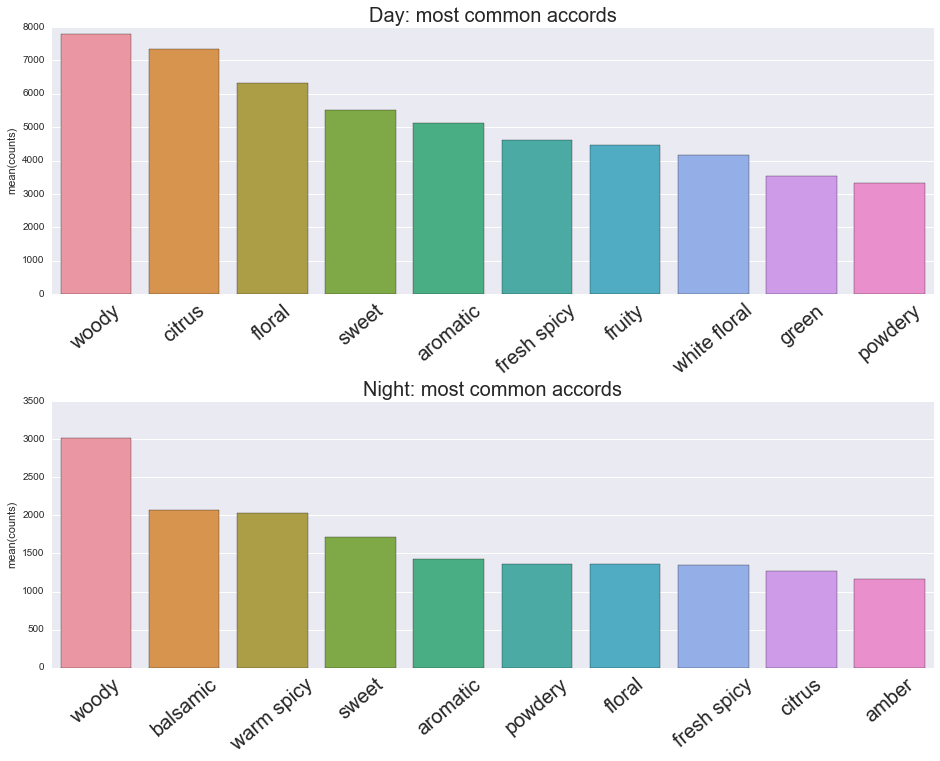

In [231]:
fig = plt.figure(figsize=(14,10))

day_accords_counts = df_day.iloc[:,220:].sum().tolist()
day_accords_sorted_index = sorted(range(len(day_accords_counts)), key=lambda k: day_accords_counts[k], reverse=True)
night_accords_counts = df_night.iloc[:,220:].sum().tolist()
night_accords_sorted_index = sorted(range(len(night_accords_counts)), key=lambda k: night_accords_counts[k], reverse=True)

plt.subplot(2, 1, 1)
day_accords = pd.DataFrame({'accords': [accords_token_list[x] for x in day_accords_sorted_index[:10]], 
                          'counts': [day_accords_counts[x] for x in day_accords_sorted_index[:10]]})
sns.barplot(x='accords', y='counts', data=day_accords)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Day: most common accords", fontsize=20)

plt.subplot(2, 1, 2)
night_accords = pd.DataFrame({'accords': [accords_token_list[x] for x in night_accords_sorted_index[:10]], 
                          'counts': [night_accords_counts[x] for x in night_accords_sorted_index[:10]]})
sns.barplot(x='accords', y='counts', data=night_accords)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Night: most common accords", fontsize=20)

plt.subplots_adjust(bottom=0.1, right=1, top=0.99, wspace=0.15, hspace=0.40)

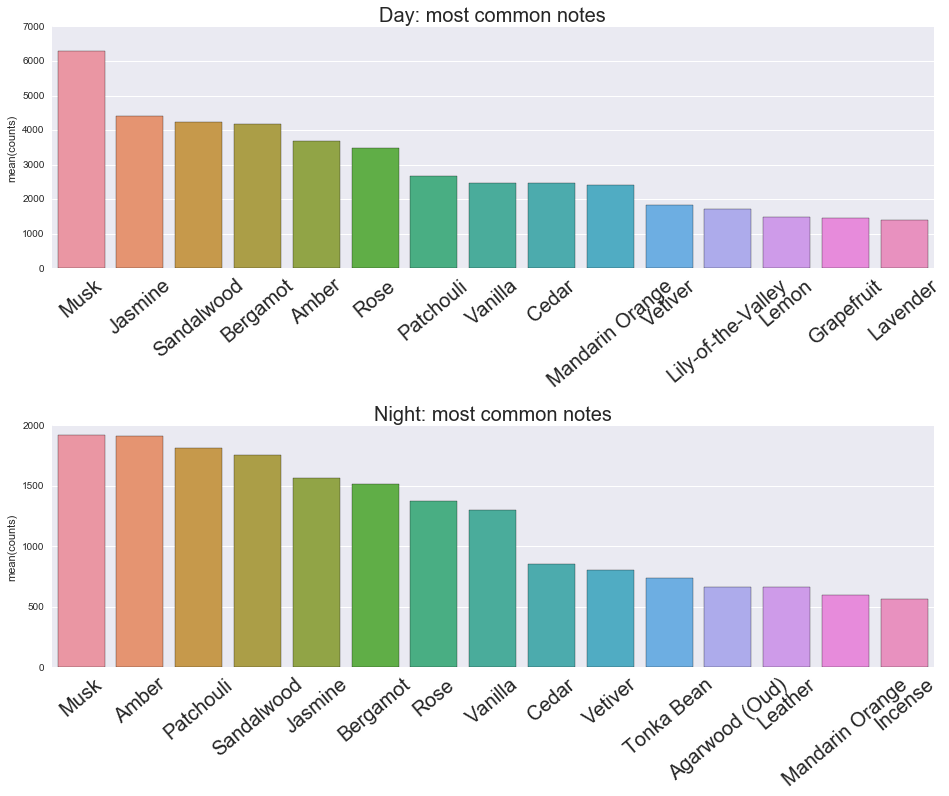

In [208]:
fig = plt.figure(figsize=(14,10))

day_notes_counts = df_day.iloc[:,20:220].sum().tolist()
day_notes_sorted_index = sorted(range(len(day_notes_counts)), key=lambda k: day_notes_counts[k], reverse=True)
night_notes_counts = df_night.iloc[:,20:220].sum().tolist()
night_notes_sorted_index = sorted(range(len(night_notes_counts)), key=lambda k: night_notes_counts[k], reverse=True)

plt.subplot(2, 1, 1)
day_notes = pd.DataFrame({'notes': [notes_token_list[x] for x in day_notes_sorted_index[:15]], 
                          'counts': [day_notes_counts[x] for x in day_notes_sorted_index[:15]]})
sns.barplot(x='notes', y='counts', data=day_notes)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Day: most common notes", fontsize=20)

plt.subplot(2, 1, 2)
night_notes = pd.DataFrame({'notes': [notes_token_list[x] for x in night_notes_sorted_index[:15]], 
                          'counts': [night_notes_counts[x] for x in night_notes_sorted_index[:15]]})
sns.barplot(x='notes', y='counts', data=night_notes)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Night: most common notes", fontsize=20)

plt.subplots_adjust(bottom=0.1, right=1, top=0.99, wspace=0.15, hspace=0.65)

## Analyze the most common accords/notes in perfumes for different seasons

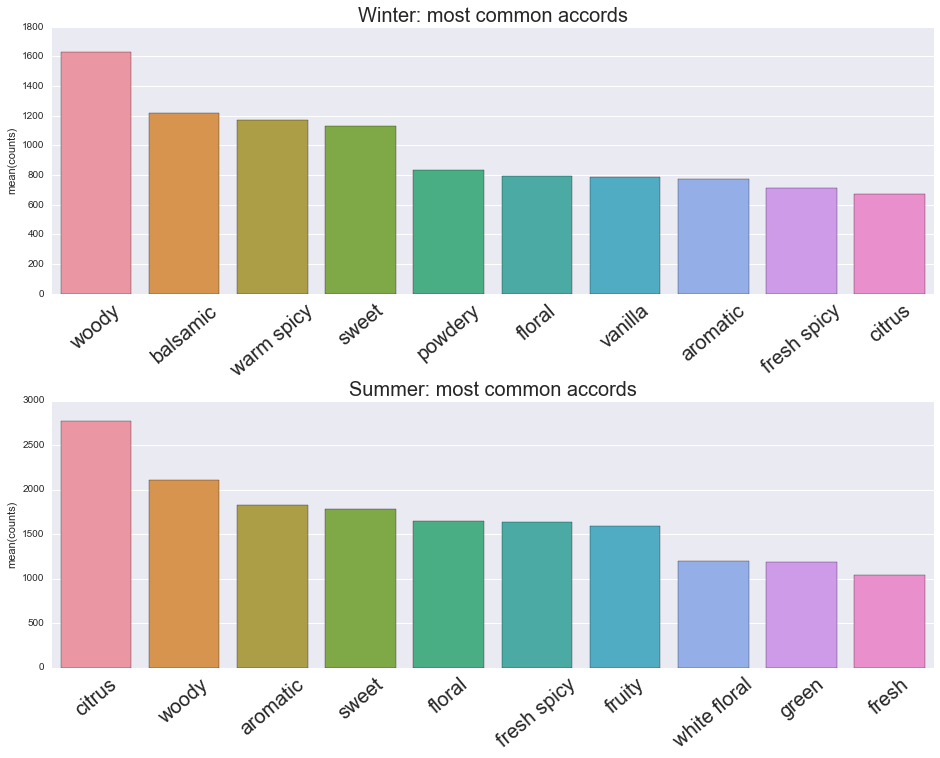

In [230]:
fig = plt.figure(figsize=(14,10))

win_accords_counts = df_win.iloc[:,220:].sum().tolist()
win_accords_sorted_index = sorted(range(len(win_accords_counts)), key=lambda k: win_accords_counts[k], reverse=True)
sum_accords_counts = df_sum.iloc[:,220:].sum().tolist()
sum_accords_sorted_index = sorted(range(len(sum_accords_counts)), key=lambda k: sum_accords_counts[k], reverse=True)

plt.subplot(2, 1, 1)
win_accords = pd.DataFrame({'accords': [accords_token_list[x] for x in win_accords_sorted_index[:10]], 
                          'counts': [win_accords_counts[x] for x in win_accords_sorted_index[:10]]})
sns.barplot(x='accords', y='counts', data=win_accords)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Winter: most common accords", fontsize=20)

plt.subplot(2, 1, 2)
sum_accords = pd.DataFrame({'accords': [accords_token_list[x] for x in sum_accords_sorted_index[:10]], 
                          'counts': [sum_accords_counts[x] for x in sum_accords_sorted_index[:10]]})
sns.barplot(x='accords', y='counts', data=sum_accords)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Summer: most common accords", fontsize=20)

plt.subplots_adjust(bottom=0.1, right=1, top=0.99, wspace=0.15, hspace=0.40)

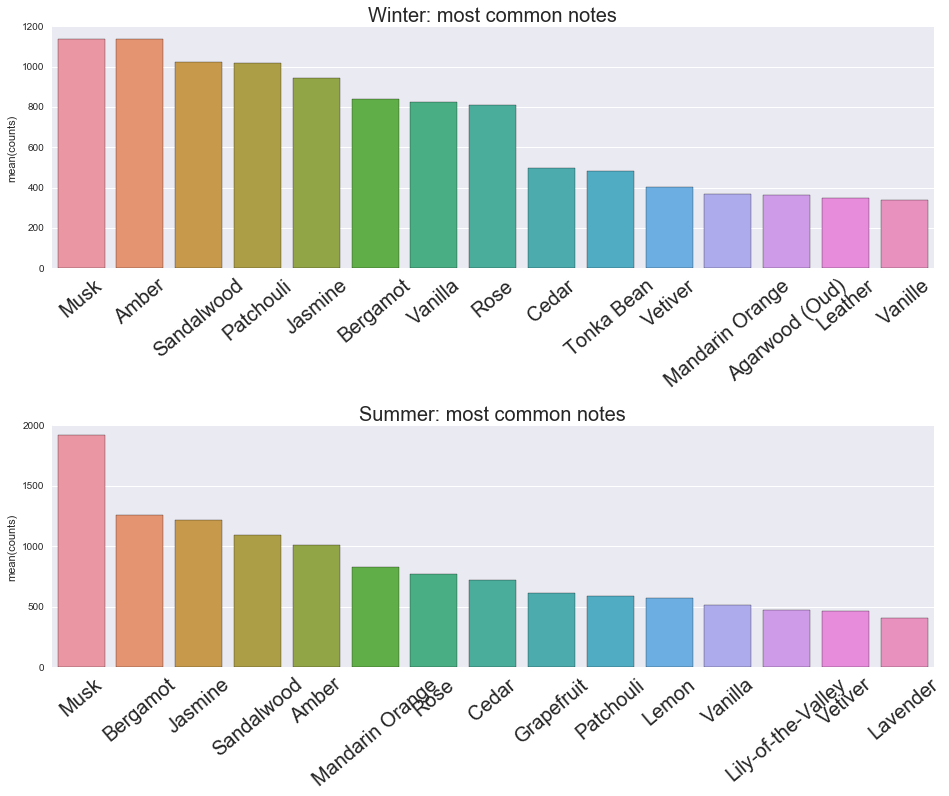

In [216]:
fig = plt.figure(figsize=(14,10))

win_notes_counts = df_win.iloc[:,20:220].sum().tolist()
win_notes_sorted_index = sorted(range(len(win_notes_counts)), key=lambda k: win_notes_counts[k], reverse=True)
sum_notes_counts = df_sum.iloc[:,20:220].sum().tolist()
sum_notes_sorted_index = sorted(range(len(sum_notes_counts)), key=lambda k: sum_notes_counts[k], reverse=True)

plt.subplot(2, 1, 1)
win_notes = pd.DataFrame({'notes': [notes_token_list[x] for x in win_notes_sorted_index[:15]], 
                          'counts': [win_notes_counts[x] for x in win_notes_sorted_index[:15]]})
sns.barplot(x='notes', y='counts', data=win_notes)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Winter: most common notes", fontsize=20)

plt.subplot(2, 1, 2)
sum_notes = pd.DataFrame({'notes': [notes_token_list[x] for x in sum_notes_sorted_index[:15]], 
                          'counts': [sum_notes_counts[x] for x in sum_notes_sorted_index[:15]]})
sns.barplot(x='notes', y='counts', data=sum_notes)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Summer: most common notes", fontsize=20)

plt.subplots_adjust(bottom=0.1, right=1, top=0.99, wspace=0.15, hspace=0.65)

## Analyze most common accords/notes in perfumes of different longevity

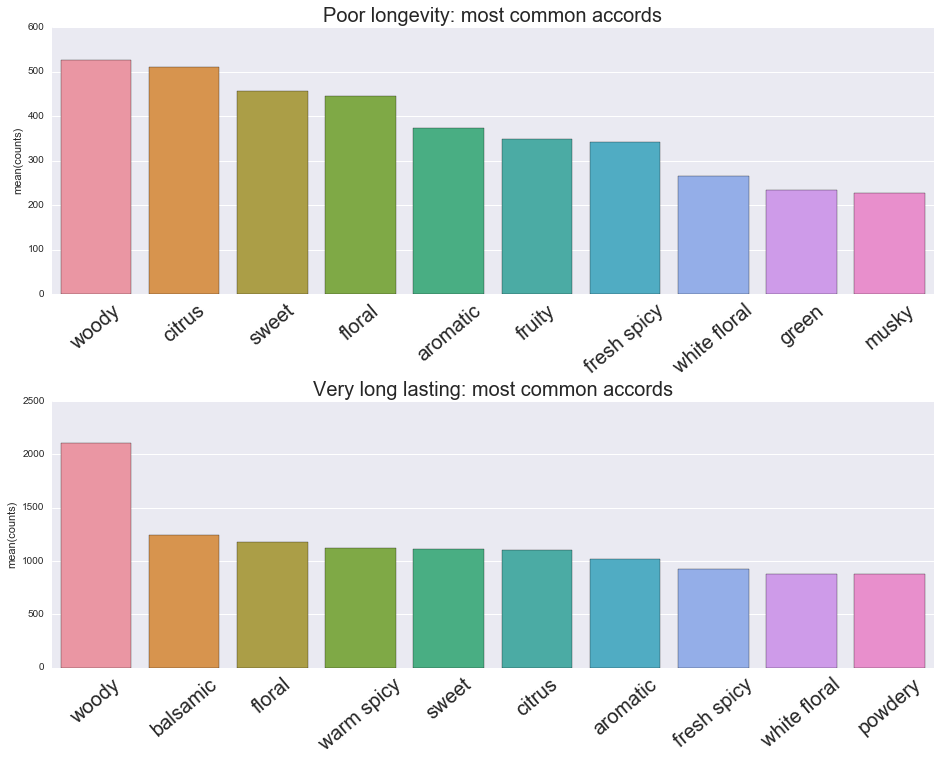

In [232]:
fig = plt.figure(figsize=(14,10))

poor_accords_counts = df_poor.iloc[:,220:].sum().tolist()
poor_accords_sorted_index = sorted(range(len(poor_accords_counts)), key=lambda k: poor_accords_counts[k], reverse=True)
very_long_accords_counts = df_very_long.iloc[:,220:].sum().tolist()
very_long_accords_sorted_index = sorted(range(len(very_long_accords_counts)), key=lambda k: very_long_accords_counts[k], 
                                        reverse=True)

plt.subplot(2, 1, 1)
poor_accords = pd.DataFrame({'accords': [accords_token_list[x] for x in poor_accords_sorted_index[:10]], 
                          'counts': [poor_accords_counts[x] for x in poor_accords_sorted_index[:10]]})
sns.barplot(x='accords', y='counts', data=poor_accords)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Poor longevity: most common accords", fontsize=20)

plt.subplot(2, 1, 2)
very_long_accords = pd.DataFrame({'accords': [accords_token_list[x] for x in very_long_accords_sorted_index[:10]], 
                          'counts': [very_long_accords_counts[x] for x in very_long_accords_sorted_index[:10]]})
sns.barplot(x='accords', y='counts', data=very_long_accords)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Very long lasting: most common accords", fontsize=20)

plt.subplots_adjust(bottom=0.1, right=1, top=0.99, wspace=0.15, hspace=0.40)

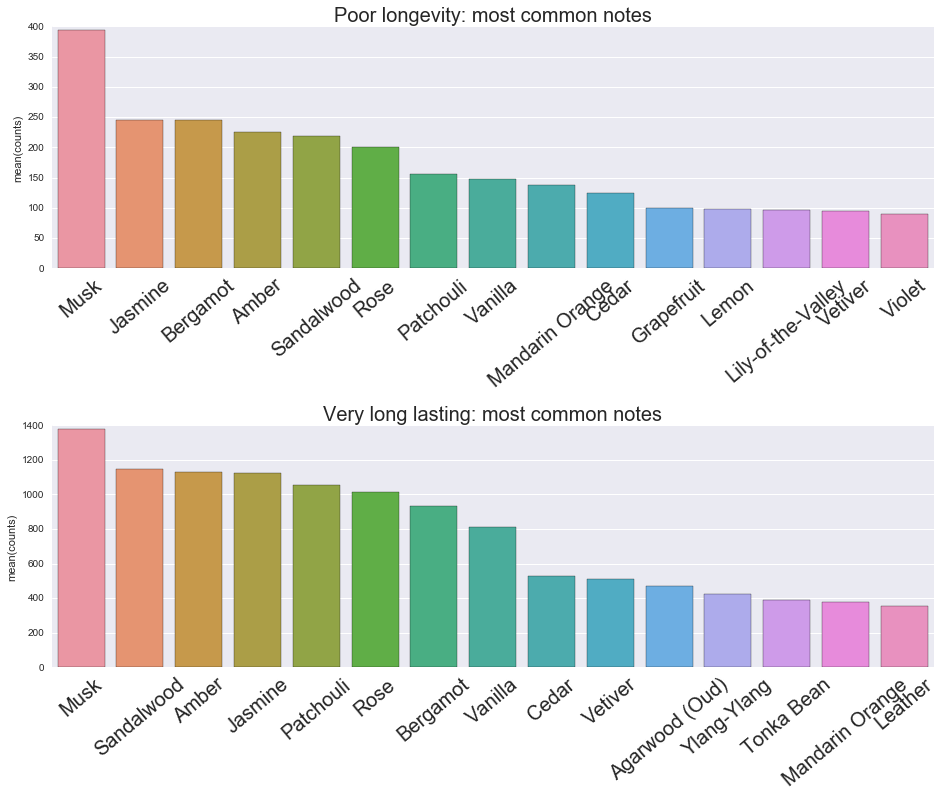

In [233]:
fig = plt.figure(figsize=(14,10))

poor_notes_counts = df_poor.iloc[:,20:220].sum().tolist()
poor_notes_sorted_index = sorted(range(len(poor_notes_counts)), key=lambda k: poor_notes_counts[k], reverse=True)
very_long_notes_counts = df_very_long.iloc[:,20:220].sum().tolist()
very_long_notes_sorted_index = sorted(range(len(very_long_notes_counts)), key=lambda k: very_long_notes_counts[k], 
                                      reverse=True)

plt.subplot(2, 1, 1)
poor_notes = pd.DataFrame({'notes': [notes_token_list[x] for x in poor_notes_sorted_index[:15]], 
                          'counts': [poor_notes_counts[x] for x in poor_notes_sorted_index[:15]]})
sns.barplot(x='notes', y='counts', data=poor_notes)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Poor longevity: most common notes", fontsize=20)

plt.subplot(2, 1, 2)
very_long_notes = pd.DataFrame({'notes': [notes_token_list[x] for x in very_long_notes_sorted_index[:15]], 
                          'counts': [very_long_notes_counts[x] for x in very_long_notes_sorted_index[:15]]})
sns.barplot(x='notes', y='counts', data=very_long_notes)
plt.xticks(rotation=40)
plt.xticks(fontsize=20)
plt.xlabel("")
plt.title("Very long lasting: most common notes", fontsize=20)

plt.subplots_adjust(bottom=0.1, right=1, top=0.99, wspace=0.15, hspace=0.65)

# ==================================================
# 3. Apply Mahcine Learning (ML) algorithms to make predictions
## 3.1 Use classifiers to predict perfume popularity
## 3.2 Use regressors to preidct perfume rating
# ==================================================

In [236]:
######################################################################################
####### define functions to compute performance of different models/algorithms #######
######################################################################################

# compute F1 score
def get_score (correct_class, predicted_class):
    correct = correct_class.tolist()
    pred = predicted_class.tolist()
    TP = 0
    FP = 0
    FN = 0
    for i in range(0, len(correct)):
        TP += int((correct[i] == 2) & (pred[i] == 2))
        FP += int((correct[i] == 1) & (pred[i] == 2))
        FN += int((correct[i] == 2) & (pred[i] == 1))
    precision = TP / (TP + FP) 
    recall = TP / (TP + FN)
    score = 2 * precision * recall / (precision + recall)
    return (score)

# compute test/traing error
def get_error (correct_class, predicted_class):
    diff = correct_class - predicted_class
    diff = diff.tolist()
    err = 1 - diff.count(0)/len(diff)
    return (err)

# compute mean absolute error for regression
def get_mean_abs_error (correct_class, predicted_class):
    y_corr = correct_class.tolist()
    y_pre = predicted_class.tolist()
    y_mean = sum(y_corr)/len(y_corr)
    error_all = []
    for i in range(0, len(y_corr)):
        err = abs(y_pre[i] - y_corr[i]) / y_corr[i]
        error_all.append(err)
    return (sum(error_all) / len(error_all))

## 3.1 Apply  classification algorithms to predict whether a perfume is popular or not

In [264]:
###############################################################
###### construct training set and test set ######
###### decide input and target (popular or not) features ######
###############################################################

# 70% data as training set, 30% as test set

size_training = int(0.7 * df.shape[0])
df_training = df.iloc[:size_training, :]
df_test = df.iloc[size_training:, :]

# select input features: day vs. night, season, longevity, sillage, notes, accords
# select target feature: whether a perfume is popular or not
x_train = df_training.iloc[:, 5:].values
y_train = df_training.iloc[:, 4].values
x_test = df_test.iloc[:, 5:].values
y_test = df_test.iloc[:, 4].values

### 3.1.1 Boosting classifier

Done model learning
The test error is 0.09197080291970805
The training error is 0.013453476002753262
Done computing error.
Done computing test errors vs. iterations
Done computing training errors vs. iterations


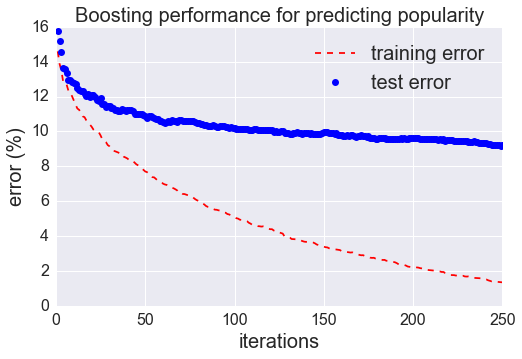

In [294]:
##################################
###### boosting classifier #######
##################################
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(max_depth=6, n_estimators=250)
clf.fit(x_train, y_train)
print ("Done model learning")

y_prediction = clf.predict(x_test)
err_test = get_error(y_test, y_prediction)
print ("The test error is {0}".format(err_test))
err_boosting = err_test * 100

y_prediction = clf.predict(x_train)
err_train = get_error(y_train, y_prediction)
print ("The training error is {0}".format(err_train))
print ("Done computing error.")

# compute training and test error vs. iterations
itr = []
err_train_list = []
err_test_list = []
for i, y_pred in enumerate(clf.staged_predict(x_test)):
    itr.append(i + 1)
    err_test = get_error(y_test, y_pred)
    err_test_list.append(err_test)
print ("Done computing test errors vs. iterations")

for i, y_pred in enumerate(clf.staged_predict(x_train)):
    #itr.append(i + 1)
    err_train = get_error(y_train, y_pred)
    err_train_list.append(err_train)
print ("Done computing training errors vs. iterations")

# plot error vs. iterations
plt.figure(figsize=(8,5))
plt.plot(itr, [x * 100 for x in err_train_list], 'r--', label="training error")
plt.plot(itr, [x * 100 for x in err_test_list], 'bo', label="test error")
plt.xlabel("iterations", fontsize=20)
plt.ylabel("error (%)", fontsize=20)
plt.title("Boosting performance for predicting popularity", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=20)

### Compute relative feature importance

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text yticklabel objects>)

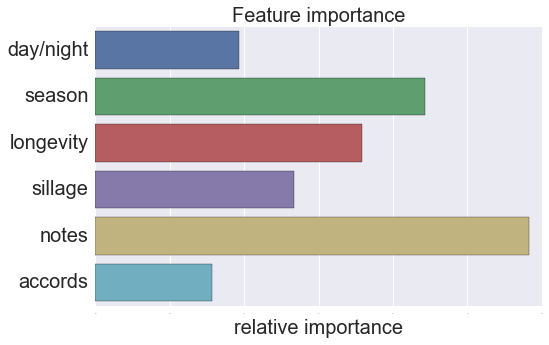

In [308]:
plt.figure(figsize=(8,5))
feature_importance = clf.feature_importances_
feature_im = feature_importance.tolist()
feature_importance = pd.DataFrame({'feature': ['day/night', 'season', 'longevity', 'sillage', 'notes', 'accords'], 
                                   'importance': [sum(feature_im[:2]), sum(feature_im[2:6]), sum(feature_im[6:11]), 
             sum(feature_im[11:15]), sum(feature_im[15:215]), sum(feature_im[215:])]})
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.xlabel("relative importance", fontsize=20)
plt.ylabel("", fontsize=20)
plt.title("Feature importance", fontsize=20)
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)

### 3.1.2 SVM: choose the kernel to be Gaussian radial basis function

In [310]:
#############################
###### SVM classifier #######
#############################
from sklearn.svm import SVC

# compute test/training error vs. gamma --> overfit or underfit

gamma_list = np.logspace(-7, 2, 20).tolist()
err_train_list = []
err_test_list = []
for x in gamma_list:
    print("************************************")
    print(gamma_list.index(x))
    print("gamma is {0}".format(x))
    clf = SVC(gamma=x)
    clf.fit(x_train, y_train)
    print ("Done model learning")

    y_prediction = clf.predict(x_test)
    err_test = get_error(y_test, y_prediction)
    err_test_list.append(err_test)
    print ("The test error is {0}".format(err_test))
    
    y_prediction = clf.predict(x_train)
    err_train = get_error(y_train, y_prediction)
    err_train_list.append(err_train)
    print ("The train error is {0}".format(err_train))
print("Done computing training/test errors vs. gamma")
err_svm = min(err_test_list) * 100

************************************
0
gamma is 1e-07
Done model learning
The test error is 0.4905109489051095
The train error is 0.4902071209561354
************************************
1
gamma is 2.976351441631319e-07
Done model learning
The test error is 0.4905109489051095
The train error is 0.4902071209561354
************************************
2
gamma is 8.858667904100833e-07
Done model learning
The test error is 0.4905109489051095
The train error is 0.4902071209561354
************************************
3
gamma is 2.6366508987303555e-06
Done model learning
The test error is 0.4905109489051095
The train error is 0.4902071209561354
************************************
4
gamma is 7.847599703514607e-06
Done model learning
The test error is 0.4905109489051095
The train error is 0.4902071209561354
************************************
5
gamma is 2.3357214690901213e-05
Done model learning
The test error is 0.4905109489051095
The train error is 0.4902071209561354
************************

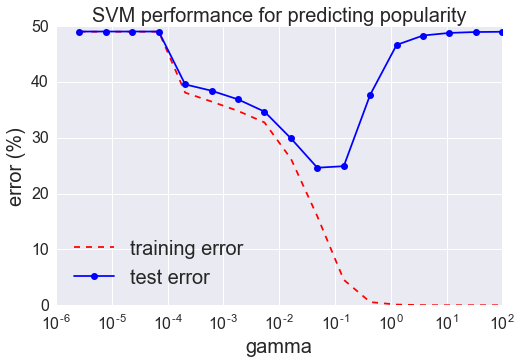

In [323]:
# plot error vs. gamma (gamma too small: underfit; too large: overfit)
plt.figure(figsize=(8,5))
plt.semilogx(gamma_list[3:], [x * 100 for x in err_train_list[3:]], 'r--', label="training error")
plt.semilogx(gamma_list[3:], [x * 100 for x in err_test_list[3:]], 'bo-', label="test error")
plt.xlabel("gamma", fontsize=20)
plt.ylabel("error (%)", fontsize=20)
plt.title("SVM performance for predicting popularity", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower left', fontsize=20)

### 3.1.3 Decision trees (DTs) classification 

In [327]:
#############################
###### DTs classifier #######
#############################

from sklearn import tree

####################################################################
# compute training/test error vs. max_depth 

depth_list = range(1, 20)
err_train_list = []
err_test_list = []
for depth in depth_list:
    print ("********************************")
    print (depth_list.index(depth))
    print ("max_depth is {}".format(depth))
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf.fit(x_train, y_train)
    print ("Done model learning")

    y_prediction = clf.predict(x_test)
    err_test = get_error(y_test, y_prediction)
    err_test_list.append(err_test)
    print ("The test error is {0}".format(err_test))
    
    y_prediction = clf.predict(x_train)
    err_train = get_error(y_train, y_prediction)
    err_train_list.append(err_train)
    print ("The train error is {0}".format(err_train))
print ("Done computing parameter dependence")
err_dts = min(err_test_list) * 100

********************************
0
max_depth is 1
Done model learning
The test error is 0.24554744525547445
The train error is 0.2498592078092735
********************************
1
max_depth is 2
Done model learning
The test error is 0.20423357664233577
The train error is 0.21087541455478376
********************************
2
max_depth is 3
Done model learning
The test error is 0.17416058394160583
The train error is 0.183029847944434
********************************
3
max_depth is 4
Done model learning
The test error is 0.16000000000000003
The train error is 0.16419498154057943
********************************
4
max_depth is 5
Done model learning
The test error is 0.15591240875912404
The train error is 0.1529316062824604
********************************
5
max_depth is 6
Done model learning
The test error is 0.15503649635036498
The train error is 0.142419122708216
********************************
6
max_depth is 7
Done model learning
The test error is 0.14744525547445253
The train error 

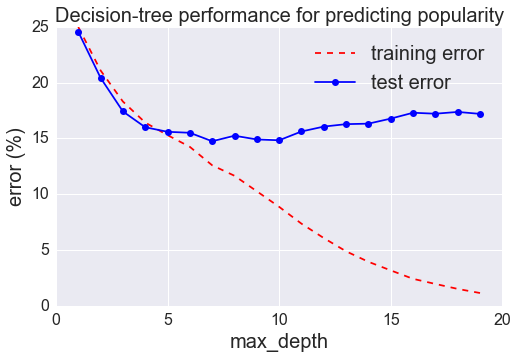

In [328]:
# plot error vs. max_depth
plt.figure(figsize=(8,5))
plt.plot(depth_list, [x * 100 for x in err_train_list], 'r--', label="training error")
plt.plot(depth_list, [x * 100 for x in err_test_list], 'bo-', label="test error")
plt.xlabel("max_depth", fontsize=20)
plt.ylabel("error (%)", fontsize=20)
plt.title("Decision-tree performance for predicting popularity", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', fontsize=20)

### 3.1.4 Naive Bayes (NB) 
### --> Not a good model here (data not satisfying the assumption of Bayes theorem)

In [351]:
##########################################
###### Naive Bayes (NB) classifier #######
##########################################

#from sklearn.naive_bayes import MultinomialNB
#clf = MultinomialNB()
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

clf.fit(x_train, y_train)
print ("Done model learning")

y_prediction = clf.predict(x_test)
err_test = get_error(y_test, y_prediction)
print ("The test error is {0:.3f}%".format(err_test * 100))
err_nb = err_test * 100

y_prediction = clf.predict(x_train)
err_train = get_error(y_train, y_prediction)
print ("The training error is {0:.3f}%".format(err_train * 100))
print ("Done computing error.")

Done model learning
The test error is 35.912%
The training error is 34.935%
Done computing error.


### Compare the test error generated by different classification models

(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.]),
 <a list of 9 Text yticklabel objects>)

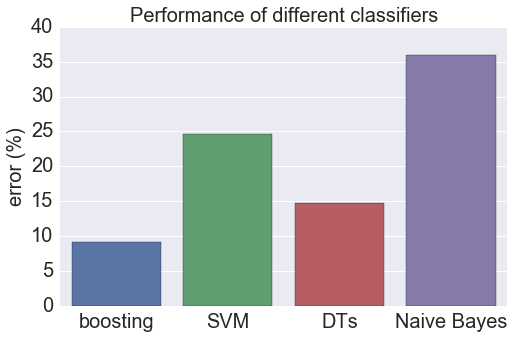

In [352]:
plt.figure(figsize=(8,5))
clf_err = pd.DataFrame({'clf_name': ['boosting', 'SVM', 'DTs', 'Naive Bayes'], 
                                   'err_test': [err_boosting, err_svm, err_dts, err_nb]})
sns.barplot(x='clf_name', y='err_test', data=clf_err)
plt.xlabel("", )
plt.ylabel("error (%)", fontsize=20)
plt.title("Performance of different classifiers", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## 3.2 Apply  regression algorithms to predict the rating of a perfume

In [355]:
###############################################################
###### change the target (popular or not) features ######
###############################################################

# select target feature: whether a perfume is popular or not
y_train = df_training.iloc[:, 2].values
y_test = df_test.iloc[:, 2].values

### 3.2.1 Linear regression

In [357]:
################################
###### Linear regression #######
################################

from sklearn import linear_model

lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)
print ("Done model learning")

y_prediction = lr.predict(x_test)
err_test = get_mean_abs_error(y_test, y_prediction)
print ("The test error is {0:.3f}%".format(err_test * 100))
err_lr = err_test * 100

y_prediction = lr.predict(x_train)
err_train = get_mean_abs_error(y_train, y_prediction)
print ("The training error is {0:.3f}%".format(err_train * 100))


Done model learning
The test error is 12.254%
The training error is 11.925%


### 3.2.1 Decision trees (DTs) regression

In [359]:
#############################
###### DTs regression #######
#############################

from sklearn.tree import DecisionTreeRegressor

####################################################################
# compute training/test error vs. max_depth 

depth_list = range(1, 20)
err_train_list = []
err_test_list = []
for depth in depth_list:
    print ("************************************")
    print (depth_list.index(depth))
    print ("max_depth is {0}".format(depth))
    regr = DecisionTreeRegressor(max_depth=depth)
    regr.fit(x_train, y_train)
    print ("Done model learning")

    y_prediction = regr.predict(x_test)
    err_test = get_mean_abs_error(y_test, y_prediction)
    err_test_list.append(err_test)
    print ("The test error is {0:.3f}%".format(err_test * 100))
    
    y_prediction = regr.predict(x_train)
    err_train = get_mean_abs_error(y_train, y_prediction)
    err_train_list.append(err_train)
    print ("The train error is {0:.3f}%".format(err_train * 100))
print ("Done computing parameter dependence")
err_dts_regr = min(err_test_list) * 100 # percent

************************************
0
max_depth is 1
Done model learning
The test error is 12.539%
The train error is 12.280%
************************************
1
max_depth is 2
Done model learning
The test error is 12.458%
The train error is 12.236%
************************************
2
max_depth is 3
Done model learning
The test error is 12.473%
The train error is 12.152%
************************************
3
max_depth is 4
Done model learning
The test error is 12.434%
The train error is 12.074%
************************************
4
max_depth is 5
Done model learning
The test error is 12.420%
The train error is 11.990%
************************************
5
max_depth is 6
Done model learning
The test error is 12.434%
The train error is 11.846%
************************************
6
max_depth is 7
Done model learning
The test error is 12.475%
The train error is 11.591%
************************************
7
max_depth is 8
Done model learning
The test error is 12.650%
The train e

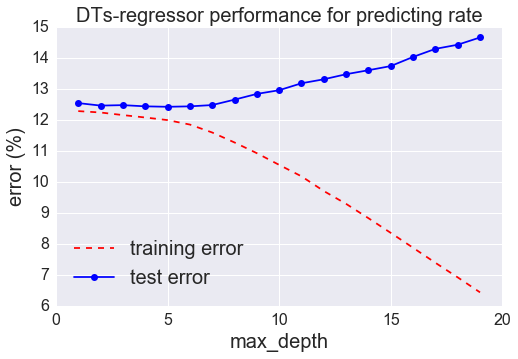

In [361]:
# plot error vs. max_depth
plt.figure(figsize=(8,5))
plt.plot(depth_list, [x * 100 for x in err_train_list], 'r--', label="training error")
plt.plot(depth_list, [x * 100 for x in err_test_list], 'bo-', label="test error")
plt.xlabel("max_depth", fontsize=20)
plt.ylabel("error (%)", fontsize=20)
plt.title("DTs-regressor performance for predicting rate", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower left', fontsize=20)

## Some conclusions
### 1. Predict perfume popularity: use classification models (boosting, etc) --> 9% error
### 2. Predict perfume rating: use regression models (linear regression, etc) --> 12% error

## Next ...
### 1. Include perfume ingredients as another input feature --> provide guidance for perfume manufactures
### 2. Interpret some ML results and provide customized advice. (E.g. predict the most popular perfumes for different seasons; what combination of perfume notes would have the highest rating)